<a href="https://colab.research.google.com/github/Kanakanajm/nnti/blob/main/NNTIProject/notebooks/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# download the requirements.txt hosted on a Github public gist
# !wget https://gist.githubusercontent.com/CamiloMartinezM/7eb6f86e2642e24776c90433c29133de/raw/8e7d8ab19bc8f55fe2e837c1d1d0fe3026519fb1/requirements.txt -O requirements.txt
# install the required libraries
# !pip install -r requirements.txt

In [2]:
# import dependencies
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import tqdm
import json
import os

from datasets import (
    load_dataset,
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)
from transformers import (
    XGLMTokenizer,
    XGLMTokenizerFast,
    XGLMForCausalLM,
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig
)

# set up figure parameters to make them look nice
plt.rcParams["axes.formatter.use_mathtext"] = True
matplotlib.rcParams["font.family"] = "cmr10"
matplotlib.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams.update({"font.size": 11})
matplotlib.rcParams['figure.dpi'] = 150

# other utils functions
from copy import deepcopy
from pprint import pprint, pformat

def left_indent(text, indent: str = "\t"):
    return "".join([indent + l for l in text.splitlines(True)])

def pprint_tab(obj, indent: str = "\t"):
    print(left_indent(pformat(obj), indent))

def get_available_objects(data):
    return [obj for obj in dir(data) if not obj.startswith("__")]

def copy(obj):
    return deepcopy(obj)

def save_tensor_to(dst: str, filename: str, t: torch.Tensor, overwrite: bool = True) -> None:
    if not os.path.exists(dst):
        os.makedirs(dst)
    fullpath = os.path.join(dst, filename)
    # save to file if it does not exist or if it does exist and overwrite = True
    if (os.path.exists(fullpath) and overwrite) or not os.path.exists(fullpath):
        torch.save(t, fullpath)

## Explore dataset

In [3]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME = "facebook/xglm-564M" # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [4]:
# Explore a dataset
LANGUAGE_CODE = "deu_Latn" # Language to explore

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder(DATA_SET_NAME, LANGUAGE_CODE, trust_remote_code=True)
print(ds_builder.info.description) # print the dataset description

The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [5]:
# print the features (columns) of the dataset
pprint(ds_builder.info.features)

{'URL': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'has_image': Value(dtype='int32', id=None),
 'id': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None)}


In [6]:
# get the available splits
pprint(ds_builder.info.splits)

None


## Load data, tokenize, and batchify

In [7]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [8]:
# Set up the splits to download
USE_SPLITS = ["dev", "devtest"]

"""
load flores data for each language
structure:
dataset_per_lang = {
  language: {
      "dataset": {
           split (dev/devtest): {
               "raw": raw dataset (without tokenization),
               "tokenized": tokenized dataset
           }
      },
      "dataloader": {
           split (dev/devtest): dataloader for the split
      }
  }
}
"""
dataset_per_lang = {}
for language in LANGUAGES:
    print(f"Loading dataset for {language}", end="... ")

    # add a dataloader key set to None, they are defined in the cell tagged
    # @dataloader-creation
    dataset_per_lang[language] = {"dataset": {}, "dataloader": None}

    for split in USE_SPLITS:
        dataset_per_lang[language]["dataset"][split] = {}
        dataset_per_lang[language]["dataset"][split]["raw"] = load_dataset(
            DATA_SET_NAME,
            language,
            split=split,
            trust_remote_code=True,
            cache_dir="../cache/languages",
        )

    print("done")

Loading dataset for eng_Latn... done
Loading dataset for spa_Latn... done
Loading dataset for ita_Latn... done
Loading dataset for deu_Latn... done
Loading dataset for arb_Arab... done
Loading dataset for tel_Telu... done
Loading dataset for tam_Taml... done
Loading dataset for quy_Latn... done


In [9]:
# let's look at the English subset
EX_DATASET_LANG = "eng_Latn"
english_dataset = dataset_per_lang[EX_DATASET_LANG]["dataset"]["dev"]["raw"]
print(f"Size of the english dataset: {english_dataset.info.dataset_size}")
print("Features:")
pprint_tab(english_dataset.info.features)
print("\nSplits:")
pprint_tab(english_dataset.info.splits)

Size of the english dataset: 501481
Features:
	{'URL': Value(dtype='string', id=None),
	 'domain': Value(dtype='string', id=None),
	 'has_hyperlink': Value(dtype='int32', id=None),
	 'has_image': Value(dtype='int32', id=None),
	 'id': Value(dtype='int32', id=None),
	 'sentence': Value(dtype='string', id=None),
	 'topic': Value(dtype='string', id=None)}

Splits:
	{'dev': SplitInfo(name='dev',
	                  num_bytes=245488,
	                  num_examples=997,
	                  shard_lengths=None,
	                  dataset_name='flores'),
	 'devtest': SplitInfo(name='devtest',
	                      num_bytes=255993,
	                      num_examples=1012,
	                      shard_lengths=None,
	                      dataset_name='flores')}


In [10]:
# let's look at an individual sample from the dataset
def get_sample(idx: int, lang: str, split: str, data: str):
    return dataset_per_lang[lang]['dataset'][split][data][idx]

print(f"Viewing raw samples from {EX_DATASET_LANG}:")
for split in USE_SPLITS:
    first_sample = get_sample(0, EX_DATASET_LANG, split, "raw")
    last_sample = get_sample(-1, EX_DATASET_LANG, split, "raw")
    dataset_len = len(dataset_per_lang[EX_DATASET_LANG]["dataset"][split]["raw"]) - 1

    print("")
    print(f"\tFirst sample from {split} split:")
    pprint_tab(first_sample, indent="\t\t")
    print("")
    print(f"\t{dataset_len}-th sample from {split} split:")
    pprint_tab(last_sample, indent="\t\t")

Viewing raw samples from eng_Latn:

	First sample from dev split:
		{'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet',
		 'domain': 'wikinews',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 1,
		 'sentence': 'On Monday, scientists from the Stanford University School of '
		             'Medicine announced the invention of a new diagnostic tool that '
		             'can sort cells by type: a tiny printable chip that can be '
		             'manufactured using standard inkjet printers for possibly about '
		             'one U.S. cent each.',
		 'topic': 'health'}

	996-th sample from dev split:
		{'URL': 'https://en.wikivoyage.org/wiki/Funeral_travel',
		 'domain': 'wikivoyage',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 997,
		 'sentence': 'In all cases, you must book by phone directly with the airline.',
		 'topic': 'Reason to travel/Funeral travel'}

	First sample from devtest split:
		{'URL': 'https

In [11]:
# global variable that defines if per-batch padding should be used, instead
# of padding over the whole dataset
PER_BATCH_PADDING = True

# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
# if this throws an error and one is using a conda environment, one has to
# install sentencepiece library: conda install -c huggingface sentencepiece
try:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME, cache_dir="../cache/tokenizers"
    )
except ValueError:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME, cache_dir="../cache/tokenizers", use_fast=False
    )

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({"pad_token": tokenizer.unk_token})


# Specify the tokenization function
# If padding is specified, then it is used inside the tokenizer function.
def tokenization(example, padding: str = None):
    return tokenizer(
        example["sentence"],
        padding=padding if padding else False,
        truncation=True if padding else False,
        return_tensors="pt",
    )

def add_batch_dimension(example):
    """
    Adds a batch dimension to the tensors.
    This function assumes the tensors are already in PyTorch tensors and simply
    unsqueezes them at the first dimension.
    See https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
    """
    example["input_ids"] = example["input_ids"].unsqueeze(0)
    example["attention_mask"] = example["attention_mask"].unsqueeze(0)
    return example


for language in dataset_per_lang:
    for split in dataset_per_lang[language]["dataset"]:
        # If we are to pad the whole dataset, set `padding` to longest and pass it
        # to the tokenization function
        if not PER_BATCH_PADDING:
            raw_dataset = copy(dataset_per_lang[language]["dataset"][split]["raw"])

            # Tokenize the dataset
            tokenized_dataset = raw_dataset.map(
                lambda example: tokenization(example, padding="longest"), batched=True
            )

            # Update the tokenized dataset with Pytorch format
            tokenized_dataset.set_format(
                type="torch", columns=["input_ids", "attention_mask"]
            )

            # Apply unsqueeze operation
            tokenized_dataset = tokenized_dataset.map(
                lambda example: add_batch_dimension(example),
                batched=False,  # Set batched=False to apply function to each example individually
            )

            dataset_per_lang[language]["dataset"][split]["tokenized"] = tokenized_dataset
        else: # If per batch padding is to be used, we cannot tokenize the dataset here,
            dataset_per_lang[language]["dataset"][split]["tokenized"] = None

In [12]:
# construct a pytorch data loader for each dataset

# Dynamically pad to the longest sequence in the batch
def per_batch_padding_collate_fn(batch, padding: str = "longest"):
    sentences = [item['sentence'] for item in batch]
    batch_padded = tokenizer(
        sentences,
        padding=padding,
        truncation=True,
        return_tensors="pt",
    )
    return batch_padded

BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

for language in dataset_per_lang:
    dataset_per_lang[language]["dataloader"] = {}
    print(f"Creating dataloaders for {language} (", end="")
    for i, split in enumerate(dataset_per_lang[language]["dataset"]):
        # If `PER_BATCH_PADDING` is False, then the padding was applied earlier and value of
        # the key 'tokenized' is not None
        # If it is True however, then we pass a collate_fn to dynamically apply padding
        # per batch and initialize the DataLoader
        if not PER_BATCH_PADDING:
            dataset = dataset_per_lang[language]["dataset"][split]["tokenized"]
        else:
            dataset = dataset_per_lang[language]["dataset"][split]["raw"]

        # Set the BATCH_SIZE equal to the length of the dataset, if BATCH_SIZE == -1
        if BATCH_SIZE == -1:
            BATCH_SIZE = len(dataset)

        if not PER_BATCH_PADDING:
            dataset_per_lang[language]["dataloader"][split] = torch.utils.data.DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        else:
            dataset_per_lang[language]["dataloader"][split] = torch.utils.data.DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                collate_fn=per_batch_padding_collate_fn,
                shuffle=True  # or False, depending on your needs
            )

        print(f"{split}: {len(dataset_per_lang[language]['dataloader'][split])}", end="")
        if i < len(dataset_per_lang[language]["dataset"]) - 1:
            print(", ", end="")

        if BATCH_SIZE == len(dataset):
            BATCH_SIZE = -1

    print(" instances)")

Creating dataloaders for eng_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for spa_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for ita_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for deu_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for arb_Arab (dev: 499, devtest: 506 instances)
Creating dataloaders for tel_Telu (dev: 499, devtest: 506 instances)
Creating dataloaders for tam_Taml (dev: 499, devtest: 506 instances)
Creating dataloaders for quy_Latn (dev: 499, devtest: 506 instances)


In [13]:
# let's take a look at a tokenized sample
def get_batch_containing_sample(data_loader, sample_id, batch_size):
    for batch_idx, batch in enumerate(data_loader):
        if sample_id < (batch_idx + 1) * batch_size and sample_id >= batch_idx * batch_size:
            return batch
    return None

def get_sample_from_batch(sample_id: int, lang: str, split: str, data_type: str, batch_size: int = BATCH_SIZE, per_batch_padding: bool = PER_BATCH_PADDING):
    if data_type == "raw":
        # Return the raw sample with the normal `get_sample` function
        sample = get_sample(sample_id, lang, split, "raw")
        return sample
    elif data_type == "tokenized" and not per_batch_padding:
        # Return the tokenized sample with the normal `get_sample` function
        sample = get_sample(sample_id, lang, split, "tokenized")
        return sample
    elif data_type == "tokenized" and per_batch_padding:
        # We fetch the batch first that contains the wanted `sample_id`
        data_loader = dataset_per_lang[lang]['dataloader'][split]
        batch = get_batch_containing_sample(data_loader, sample_id, batch_size)
        if batch is not None:
            # Adjust indexing based on `batch` and `sample_id`
            index_within_batch = sample_id % batch_size
            tokenized_sample = {
                'input_ids': batch['input_ids'][index_within_batch],
                'attention_mask': batch['attention_mask'][index_within_batch]
            }
            return tokenized_sample
    else:
        return None

# Sample ID and language
LOOKAT_SAMPLE_ID = 17
EX_DATASET_LANG = "eng_Latn"

# get raw and tokenized sample
raw_sample = get_sample_from_batch(LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "raw")
tokenized_sample = get_sample_from_batch(LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "tokenized")

print(f"Viewing {LOOKAT_SAMPLE_ID}-th sample from {EX_DATASET_LANG}:")
print("\tRaw sample:")
pprint_tab(raw_sample, indent="\t\t")
print("\n\tTokenized sample:")
pprint_tab(tokenized_sample, indent="\t\t")

EX_DATASET_LANG = "spa_Latn"

raw_sample = get_sample_from_batch(LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "raw")
tokenized_sample = get_sample_from_batch(LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "tokenized")

print(f"\nViewing {LOOKAT_SAMPLE_ID}-th sample from {EX_DATASET_LANG}:")
print("\tRaw sample:")
pprint_tab(raw_sample, indent="\t\t")
print("\n\tTokenized sample:")
pprint_tab(tokenized_sample, indent="\t\t")

Viewing 17-th sample from eng_Latn:
	Raw sample:
		{'URL': 'https://en.wikinews.org/wiki/Investigation_of_Deutsche_Bank_headquarters_spills_into_second_day',
		 'domain': 'wikinews',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 18,
		 'sentence': 'British newspaper The Guardian suggested Deutsche Bank '
		             'controlled roughly a third of the 1200 shell companies used to '
		             'accomplish this.',
		 'topic': 'crime'}

	Tokenized sample:
		{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
		        1, 1, 1]),
		 'input_ids': tensor([     2,    984,  83801,     72,    501,     32,  15307,     48,  27562,
		           331,  87064,     48,     32,   6073,     48,  53946,     22,  25868,
		            53,    254,     11,  45876, 162437,     33,    155,  67728,      5])}

Viewing 17-th sample from spa_Latn:
	Raw sample:
		{'URL': 'https://en.wikinews.org/wiki/Investigation_of_Deutsche_Bank_headquarters_spills_into_se

## Load model

In [14]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, cache_dir="../cache/models")

# specify device on model and put the model into evaluation mode
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
model = model.eval()
print(f"Using device: {device}")

Using device: cuda


In [15]:
# define the cross-entropy loss function
def cross_entropy_loss(logits: torch.Tensor, labels: torch.Tensor, attention_mask: torch.Tensor) -> float:
    # logits are of shape: (batch_size, sequence_length, vocab_size)
    # convert logits to probabilities in the last dimension
    # that is, probs[:, i] = e^{probs[:, i]} / sum(e^{probs[:, j]})
    probs = torch.nn.functional.softmax(logits, dim=-1) # shape: [1, 84, 256008]

    # use `torch.gather` to pick out the probabilities of the actual tokens of the sentence given by the labels
    # these probabilities are saved in the last dimension, so dim=-1
    # we need to unsqueeze labels to match the dimensions of `probs`, and then squeeze back the result
    # see: https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
    index = labels.squeeze(1).unsqueeze(-1) # shape: (batch_size, sequence_length, 1), e.g, [2, 1, 73] -> [2, 73, 1]
    actual_probs = torch.gather(probs, dim=-1, index=index).squeeze(-1)

    # compute the negative log-likelihood, adding a small offset to prevent log(0)
    nll = -torch.log(actual_probs + 1e-9)

    # apply the attention mask to ignore padding positions
    attention_mask = attention_mask.to(dtype=nll.dtype)
    nll_masked = nll * attention_mask

    # sum up the negative log-likelihood of each token (taking into account the mask) and dividing by the number of
    # actual tokens in the sentence to get the Expected Value
    ce_loss = torch.sum(nll_masked) / torch.sum(attention_mask)
    return ce_loss.item()

In [16]:
# test cross-entropy loss on a sample
USE_MANUAL_CROSS_ENTROPY_LOSS_FN = False # Set to True if `cross_entropy_loss` is to be used

inputs = tokenized_sample["input_ids"].unsqueeze(0).to(device) # Add batch dimension, so that dimension match the expected model input
labels = tokenized_sample["input_ids"].unsqueeze(0).to(device)
attention_mask = tokenized_sample["attention_mask"].unsqueeze(0).to(device)

# torch.inference_mode() is now preferred over torch.no_grad().
# See: https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099/2?u=timgianitsos
with torch.inference_mode():
    outputs = model(
        inputs,
        labels=labels,
        attention_mask=attention_mask,
    )
    if USE_MANUAL_CROSS_ENTROPY_LOSS_FN:
        loss = cross_entropy_loss(outputs.logits, labels, attention_mask)
    else:
        loss = outputs.loss.item()

print(f"Outputs shape: {outputs.logits.shape}") # (batch_size, sequence_length, vocab_size)
print(f"Cross-entropy loss of the sample: {loss}")

Outputs shape: torch.Size([1, 43, 256008])
Cross-entropy loss of the sample: 9.953923225402832


In [17]:
# store per-batch losses for each split in each language
losses = {lang: {} for lang in LANGUAGES}

# Frees unused memory so it can be used by other tensors
torch.cuda.empty_cache()
try:
    # delete variables if they exist
    del inputs, labels, outputs
except NameError:
    pass

# TODO: Revise this to make sure it uses the cross-entropy loss
# iterate over the dataset for each language and compute the cross-entropy loss per batch
for language in dataset_per_lang:
    print(f"Computing losses for {language} (", end="")
    for j, split in enumerate(dataset_per_lang[language]["dataset"]):
        print(f"{split}: ", end="")
        dataloader = dataset_per_lang[language]["dataloader"][split]
        losses[language][split] = []
        for i, batch in enumerate(dataloader):
            inputs = batch["input_ids"].to(device)
            labels = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # torch.inference_mode() is now preferred over torch.no_grad().
            # See: https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099/2?u=timgianitsos
            with torch.inference_mode():
                outputs = model(inputs, labels=labels, attention_mask=attention_mask)
                if USE_MANUAL_CROSS_ENTROPY_LOSS_FN:
                    loss = cross_entropy_loss(outputs.logits, labels, attention_mask)
                else:
                    loss = outputs.loss.item()

            losses[language][split].append(loss)

            # Explicitly delete tensors to free up GPU memory
            del inputs, labels, attention_mask, outputs

        print(f"{np.mean(losses[language][split])}", end="")
        if j < len(dataset_per_lang[language]["dataset"]) - 1:
            print(", ", end="")

    print(" per-batch mean)")

    # After processing each language, try to free up memory explicitly
    torch.cuda.empty_cache()  # Frees unused memory so it can be used by other tensors

Computing losses for eng_Latn (dev: 9.280697355289497, devtest: 9.190948134825636 per-batch mean)
Computing losses for spa_Latn (dev: 9.800908632412224, devtest: 9.801382622699963 per-batch mean)
Computing losses for ita_Latn (dev: 9.929419575807804, devtest: 9.66043931599191 per-batch mean)
Computing losses for deu_Latn (dev: 10.254350311053779, devtest: 10.305495355440224 per-batch mean)
Computing losses for arb_Arab (dev: 9.048282177032593, devtest: 8.908040222914323 per-batch mean)
Computing losses for tel_Telu (dev: 8.05520539579984, devtest: 7.94367191914042 per-batch mean)
Computing losses for tam_Taml (dev: 8.223598345964849, devtest: 8.336796089594543 per-batch mean)
Computing losses for quy_Latn (dev: 11.786547938903013, devtest: 11.616116347520247 per-batch mean)


In [18]:
# save the losses to a json file
if not os.path.exists("../cache/losses"):
    os.makedirs("../cache/losses")

with open(f"../cache/losses/losses_batchsize_{BATCH_SIZE}_perbatchpadding_{PER_BATCH_PADDING}.json", "w") as f:
    json.dump(losses, f, sort_keys=True, indent=4)

## Visualize loss per language

In [19]:
# load the variable `losses` from the json file if it doesn't exist
try:
    # check if `losses` is defined and has data
    if not 'losses' in locals() or not losses:
        raise NameError  # Trigger the exception if not defined or empty
except NameError:
    # if `losses` is not defined or is empty, load it from the JSON file, if it exists
    # if the JSON file does not exists, then nothing will be loaded, therefore the
    # `Load Model` cells must be ran
    if os.path.exists(f"../cache/losses/losses_batchsize_{BATCH_SIZE}_perbatchpadding_{PER_BATCH_PADDING}.json"):
        with open(f"../cache/losses/losses_batchsize_{BATCH_SIZE}_perbatchpadding_{PER_BATCH_PADDING}.json", "r") as f:
            losses = json.load(f)

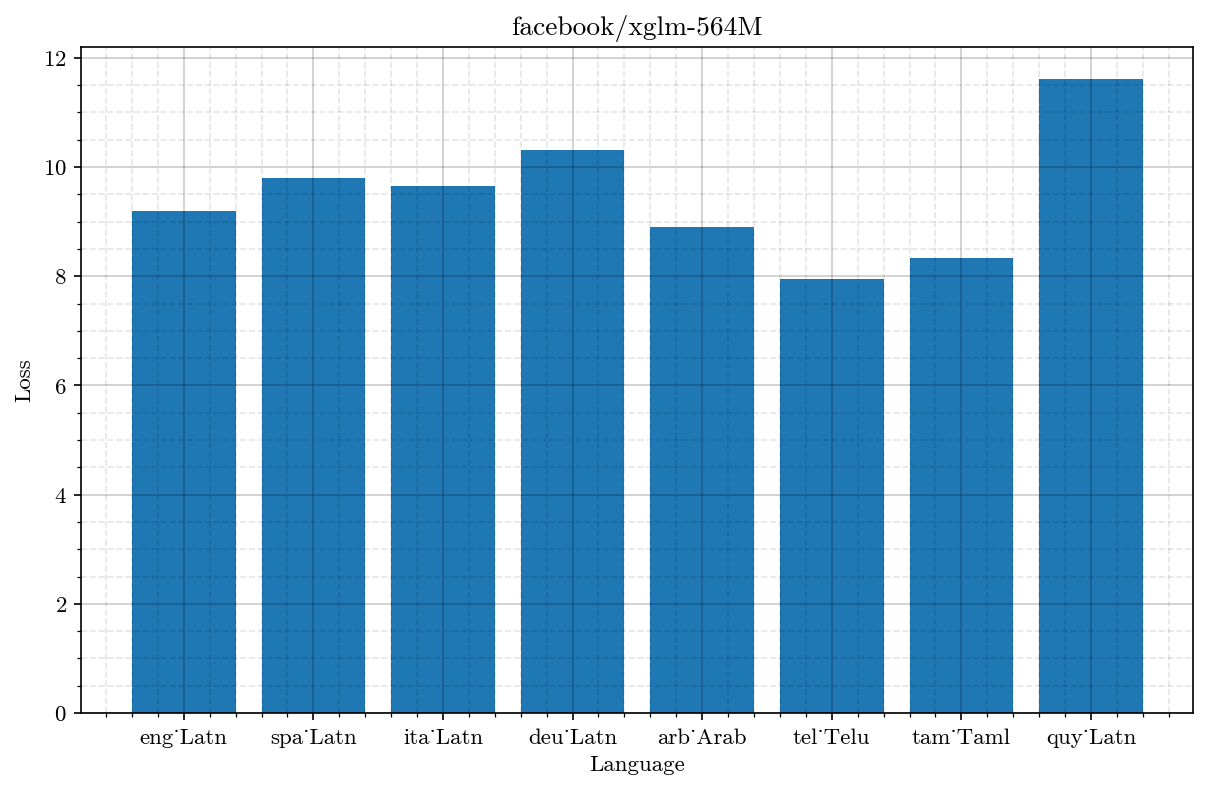

In [22]:
SPLIT_TO_CHECK = "devtest"

# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each language
x = np.arange(len(LANGUAGES))
y = [np.mean(losses[_][SPLIT_TO_CHECK]) for _ in LANGUAGES]

axes.bar(x, y)

fig.tight_layout()

# format plot
axes.set_xlabel("Language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses.keys()) # x-axis tick labels
axes.set_ylabel("Loss") # y-axis label
axes.set_title(MODEL_NAME); # title
axes.grid(True, which='major', color='k', linestyle='-', alpha=0.2)
axes.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
axes.minorticks_on()

## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well.

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [21]:
# TODO: your code goes here